## **Import libs:**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.tv_tensors import Image, Mask
from torchvision.datasets import OxfordIIITPet
import torchvision.transforms.v2 as T
from tqdm import tqdm

In [2]:
EPOCHS = 100
BATCHSIZE = 4
LR = 1e-4

## **Check Gpu:**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## **Architecture:**

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias= False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias= False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, X):
        return self.net(X)


class Encoder(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.blocks = nn.ModuleList([DoubleConv(channels[i], channels[i+1]) for i in range (len(channels) - 1)])
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, X):
        skips = []
        for current_block in (self.blocks):
            X = current_block(X)
            skips.append(X)
            X = self.pool(X)

        return X, skips

class Decoder(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.blocks = nn.ModuleList([DoubleConv(channels[i + 1] * 2, channels[i+1]) for i in range (len(channels) - 1 )])
        self.up_conv = nn.ModuleList([nn.ConvTranspose2d(channels[i], channels[i + 1], 2, 2) for i in range(len(channels) - 1)])

    def forward(self, X, skip_connection):
        for idx, (current_block, current_up_conv) in enumerate(zip(self.blocks, self.up_conv)):
            X = current_up_conv(X)
            X = torch.cat([X, skip_connection[-(idx + 1)]], dim=1)
            X = current_block(X)

        return X

class Unet(nn.Module):
    def __init__(self, nb_class):
        super(Unet, self).__init__()
        self.encoder = Encoder([3, 64, 128, 256])
        self.bottleneck = DoubleConv(256, 512)
        self.decoder = Decoder([512, 256, 128, 64])
        self.head = nn.Conv2d(64, nb_class, 1)

    def forward(self, X):
        X, skip_connection = self.encoder(X)
        X = self.bottleneck(X)
        X = self.decoder(X, skip_connection)
        X = self.head(X)
        return X


model= Unet(3).to(device)
print(model)


Unet(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0): DoubleConv(
        (net): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (1): DoubleConv(
        (net): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tr

## **DataGenerator:**

In [5]:
train_transform = T.Compose([
    T.Resize((512, 512)),
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomRotation(degrees = 15),
])

val_transform = T.Compose([
    T.Resize((512, 512)),
])

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet
import torchvision.transforms.v2 as T

############################################
##  Animal = 1 class with dogs and cats   ##
############################################

class OxfordPetSegmentation(Dataset):
    def __init__(self, root, split = "trainval", transforms = None):
        self.dataset = OxfordIIITPet(root=root, download=True, split = split, target_types = ["segmentation", "category"])
        self.transforms = transforms
        self.classes = self.dataset.classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, (mask, label) = self.dataset[idx]

        mask_np = np.array(mask)
        animal_pixels = (mask_np == 1) 

        multiclass_mask = np.zeros_like(mask_np, dtype=np.uint8)
        multiclass_mask[animal_pixels] = 1
        
        image_dp = Image(image)
        mask_dp = Mask(multiclass_mask)

        # Apply geometric transforms to datapoints
        if self.transforms:
            # Transforms that work on (dp.Image, dp.Mask) will keep them synchronized
            image_dp, mask_dp = self.transforms(image_dp, mask_dp)

        image_tensor = T.ToDtype(torch.float32, scale=True)(image_dp)
        mask_tensor = torch.as_tensor(mask_dp, dtype=torch.long)

        return image_tensor, mask_tensor


In [7]:
train_datset = OxfordPetSegmentation(root = "data", split = "trainval", transforms = train_transform)
val_datset = OxfordPetSegmentation(root = "data", split = "test", transforms = val_transform)

In [8]:
img, mask = train_datset[0]
print(img.shape)    # [3, 512, 512]
print(mask.shape)   # [512, 512]
print(torch.unique(mask))  # tensor([0, 1, 2])


torch.Size([3, 512, 512])
torch.Size([512, 512])
tensor([0, 1])


/!\ Num_worker = 1 on my Windows Computer...

In [9]:
train_loader = DataLoader(train_datset, batch_size = BATCHSIZE, shuffle = True, num_workers= 0)
val_loader = DataLoader(val_datset, batch_size = BATCHSIZE, shuffle = True, num_workers= 0)

## **Training:**

In [10]:
# Loss: CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [11]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    pbar = tqdm(dataloader, desc="Train", leave = False)
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})
    return running_loss / len(dataloader)

In [12]:
def compute_confusion(preds, targets, class_id):
    """
    preds, targets: [B, H, W] torch tensors
    class_id: int (1=cat, 2=dog)
    """
    preds_c = preds == class_id
    targets_c = targets == class_id

    tp = (preds_c & targets_c).sum().item()
    fp = (preds_c & ~targets_c).sum().item()
    fn = (~preds_c & targets_c).sum().item()

    return tp, fp, fn



def precision_recall_f1_iou(tp, fp, fn, eps=1e-8):
    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)
    iou       = tp / (tp + fp + fn + eps)
    return precision, recall, f1, iou


In [13]:
@torch.no_grad()
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0

    stats = {
        "animal" : {"tp": 0, "fp": 0, "fn": 0}
    }


    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        tp, fp, fn = compute_confusion(preds, masks, class_idx + 1) # Because class are 1 and 2
        stats["animal"]["tp"] += tp
        stats["animal"]["fp"] += fp
        stats["animal"]["fn"] += fn
    metrics = {}
    tp = stats["animal"]["tp"]
    fp = stats["animal"]["fp"]
    fn = stats["animal"]["fn"]

    precision, recall, f1, iou = precision_recall_f1_iou(tp, fp, fn, eps = 1e-8)
    metrics["animal"] = {
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "iou": iou,
    }
    return running_loss / len(dataloader), metrics

In [14]:
best_iou = 0.0
train_loss = []
val_loss = []
animal_iou = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_metrics = validate_one_epoch(model, val_loader, criterion, device)
    mean_iou = (
        val_metrics["animal"]["iou"]
    ) / 1

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val   Loss: {val_loss:.4f}")
    print(
        f"Mean IoU: {mean_iou:.3f} | "
        f"Animal IoU: {val_metrics['animal']['iou']:.3f}"
    )

    for cls in ["animal"]:
        m = val_metrics[cls]
        print(
            f"{cls.upper()} → "
            f"P: {m['precision']:.3f} "
            f"R: {m['recall']:.3f} "
            f"F1: {m['f1']:.3f}"
        )

    if mean_iou > best_iou:
        best_iou = mean_iou
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved")

    train_loss.append(train_loss)
    val_loss.append(val_loss)
    animal_iou.append(val_metrics['animal']['iou'])
    

torch.save(model.state_dict(), "final_model.pth")

model.load_state_dict(torch.load("best_model.pth"))
model.eval()

Epoch 1/100


KeyboardInterrupt: 

In [ ]:
### Plotting the history curves
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend("Evolution of the Loss during the training")
plt.show()


plt.figure(2)
plt.plot(animal_iou, label='Animal IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend("Evolution of the IoUs during the training")
plt.show()


## **Testing:**

In [15]:
def compute_metrics_binary(pred, target):
    pred = pred.bool()
    target = target.bool()

    tp = (pred & target).sum().item()
    fp = (pred & ~target).sum().item()
    fn = (~pred & target).sum().item()

    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)
    iou       = tp / (tp + fp + fn + 1e-8)

    return precision, recall, f1, iou


In [ ]:
from matplotlib import pyplot as plt
import torch

%matplotlib inline

@torch.no_grad()
def testing(model, dataloader, device, num_batches=1):
    model.eval()

    metrics = {
        "animal": {"precision": [], "recall": [], "f1": [], "iou": []},
    }

    for batch_idx, (imgs, masks) in enumerate(dataloader):
        if batch_idx >= num_batches:
            break

        imgs = imgs.to(device)
        masks = masks.to(device)

        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        imgs = imgs.cpu()
        masks = masks.cpu()
        preds = preds.cpu()

        for i in range(imgs.size(0)):
            img = imgs[i].permute(1, 2, 0)
            gt = masks[i]
            pr = preds[i]

            # ===== Metrics =====
            # Animal
            p, r, f1, iou = compute_metrics_binary(pr == 1, gt == 1)
            metrics["animal"]["precision"].append(p)
            metrics["animal"]["recall"].append(r)
            metrics["animal"]["f1"].append(f1)
            metrics["animal"]["iou"].append(iou)

            # ===== Plot =====
            fig, axs = plt.subplots(2, 2, figsize=(12, 8))
            fig.suptitle(
                f"Sample {i} | "
                f"Animal IoU: {metrics['animal']['iou'][-1]:.3f}",
                fontsize=14
            )

            axs[0, 0].imshow(img)
            axs[0, 0].set_title("Input Image")
            axs[0, 0].axis("off")

            axs[0, 1].imshow(gt == 1, cmap="gray")
            axs[0, 1].set_title("GT - Animal")
            axs[0, 1].axis("off")

            axs[1, 1].imshow(pr == 1, cmap="gray")
            axs[1, 1].set_title("Pred - Animal")
            axs[1, 1].axis("off")

            axs[1, 0].axis("off")
            plt.tight_layout()
            plt.show()

    # ===== Aggregate results =====
    print("\n===== FINAL METRICS =====")
    for cls in ["animal"]:
        print(f"\nClass: {cls}")
        for m in metrics[cls]:
            print(f"{m}: {sum(metrics[cls][m]) / len(metrics[cls][m]):.4f}")


4
Aloo


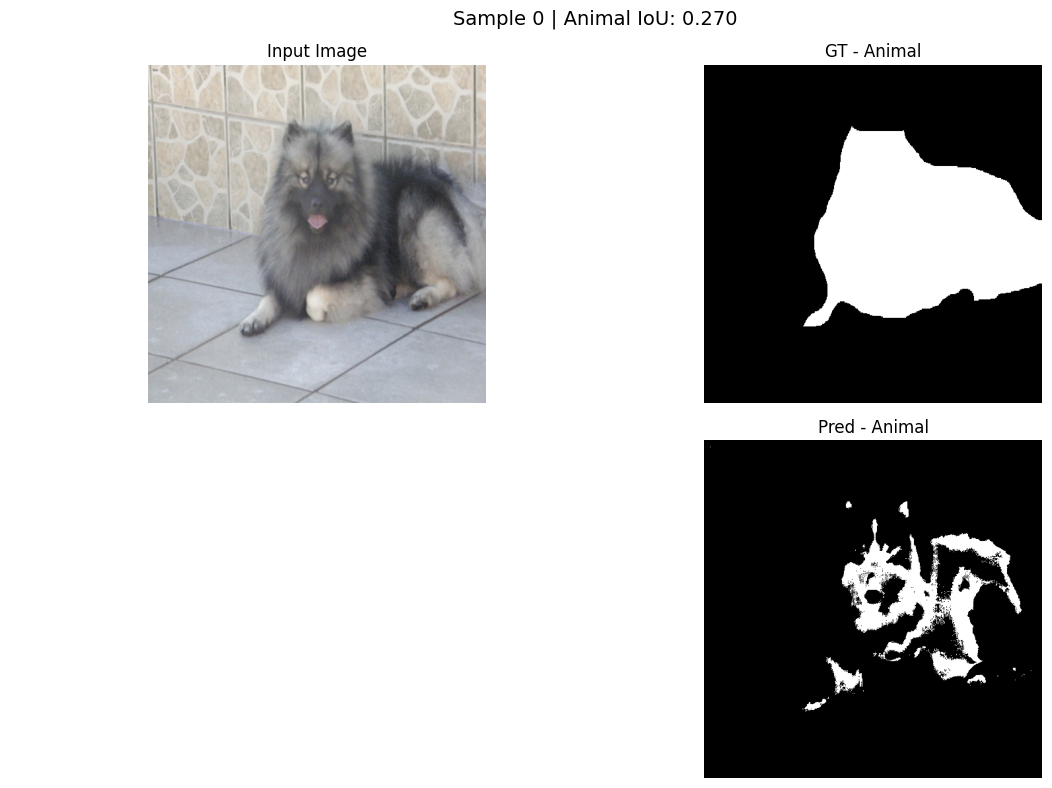

Aloo


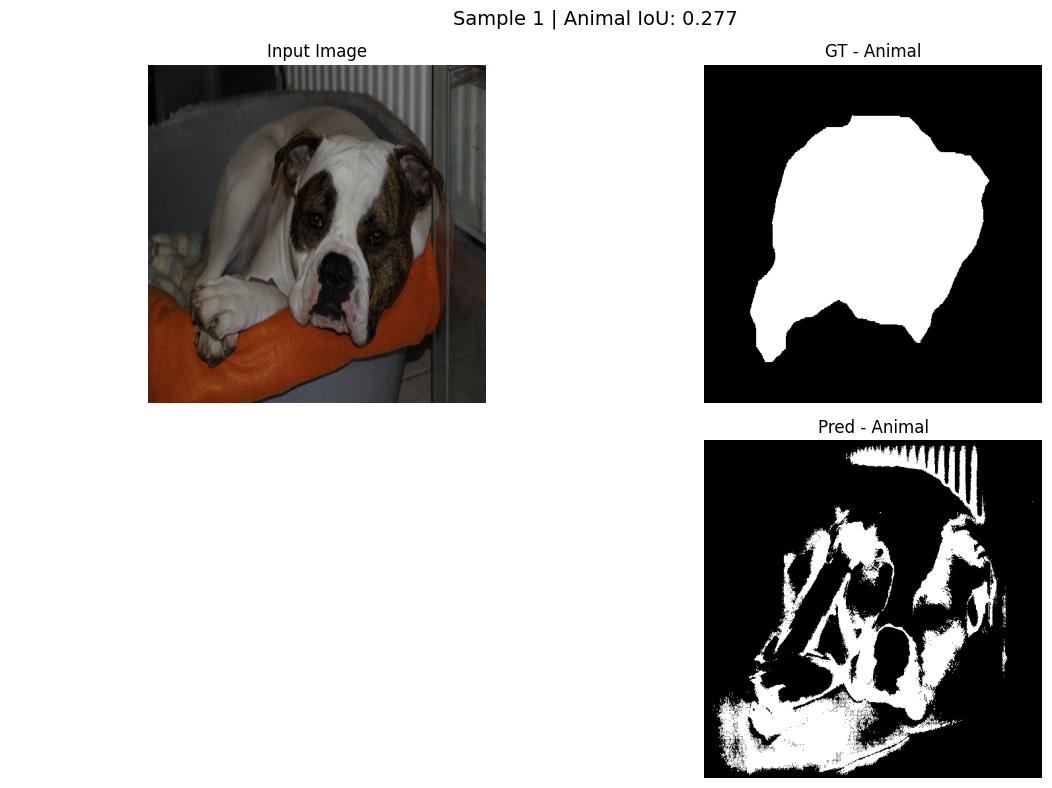

Aloo


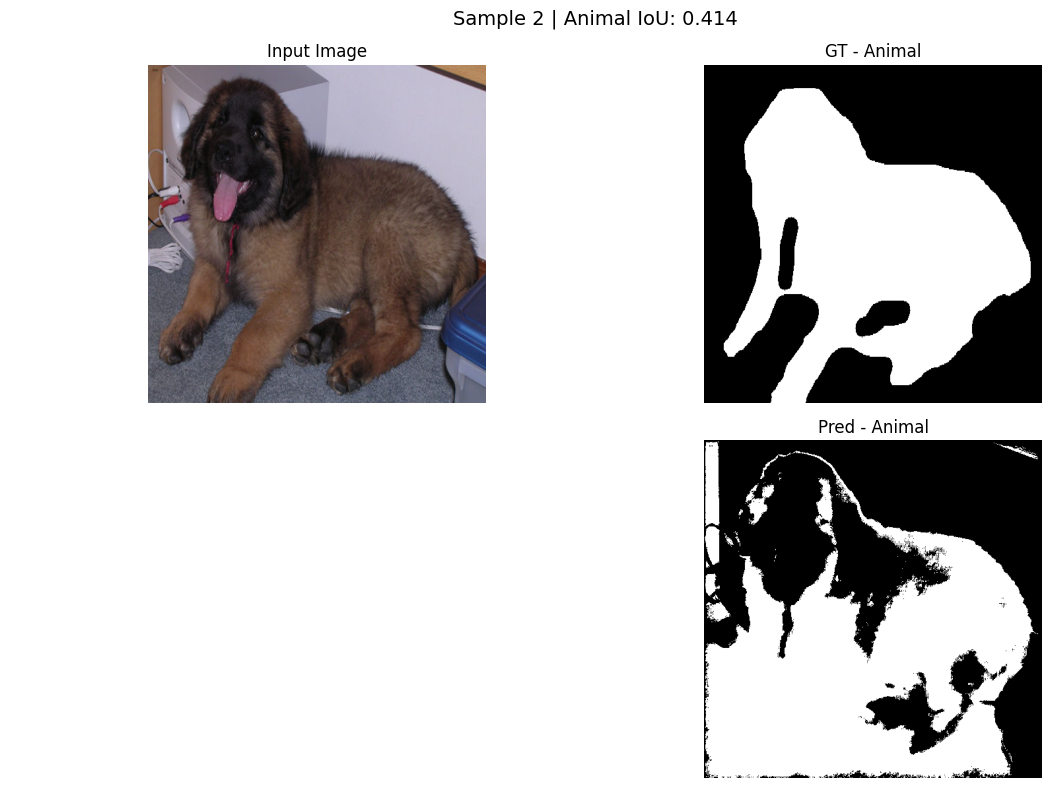

Aloo


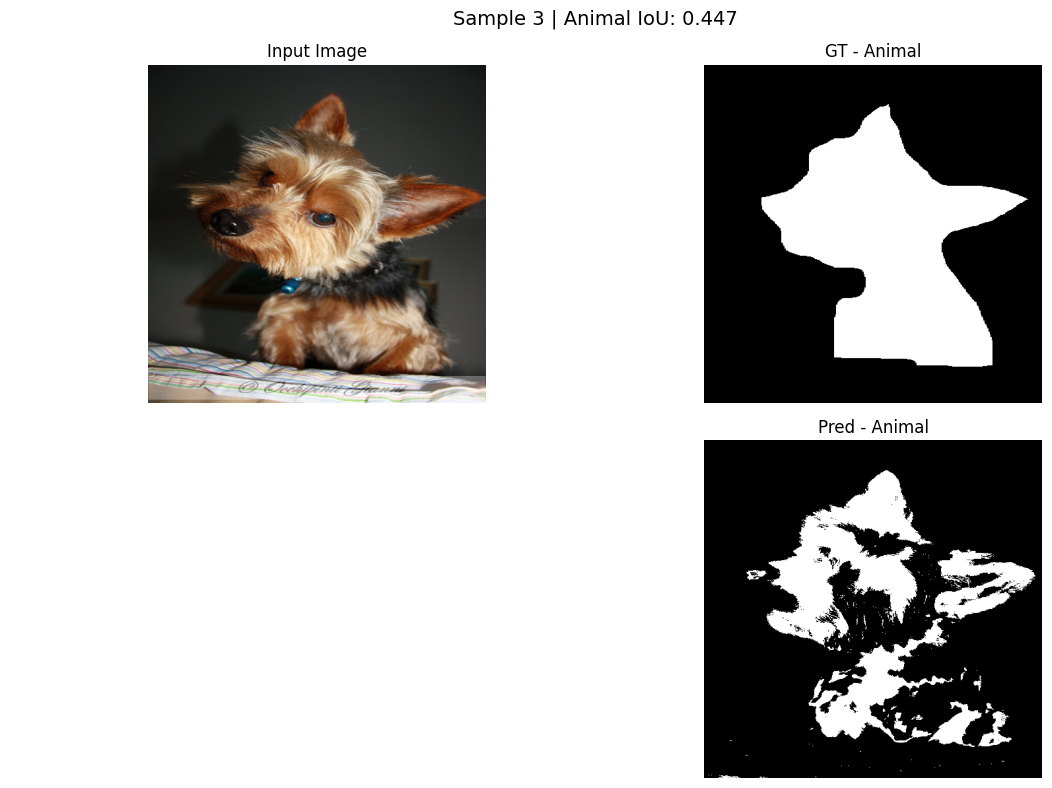

4
Aloo


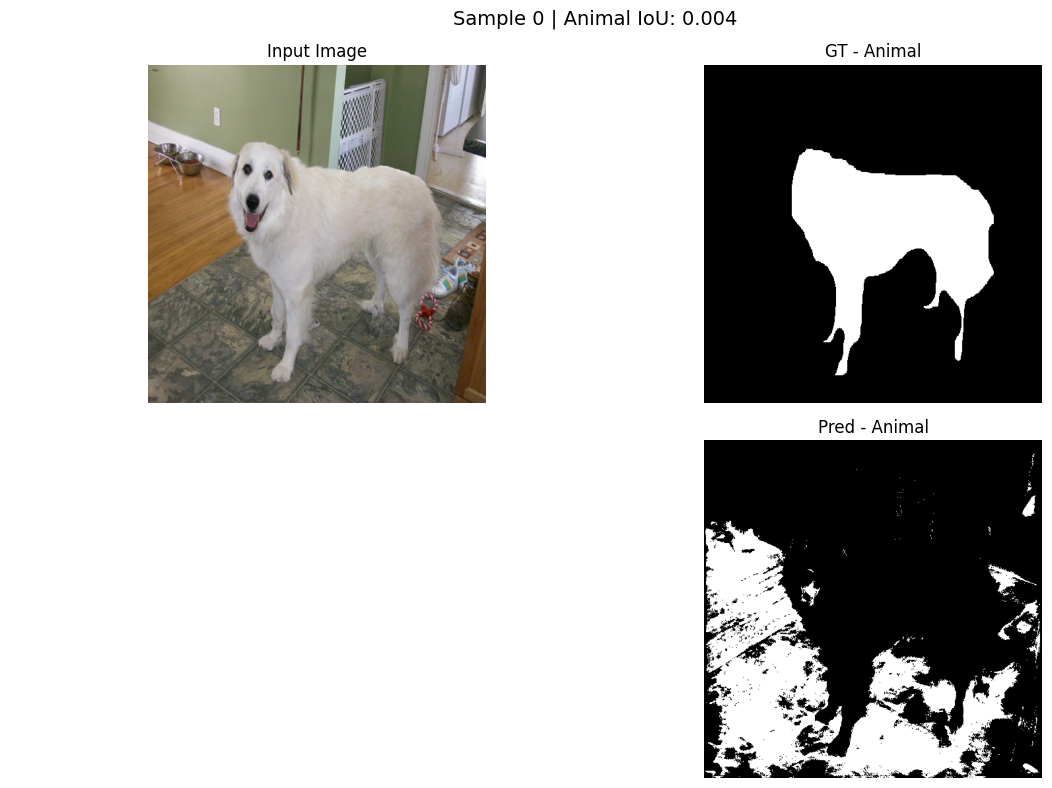

Aloo


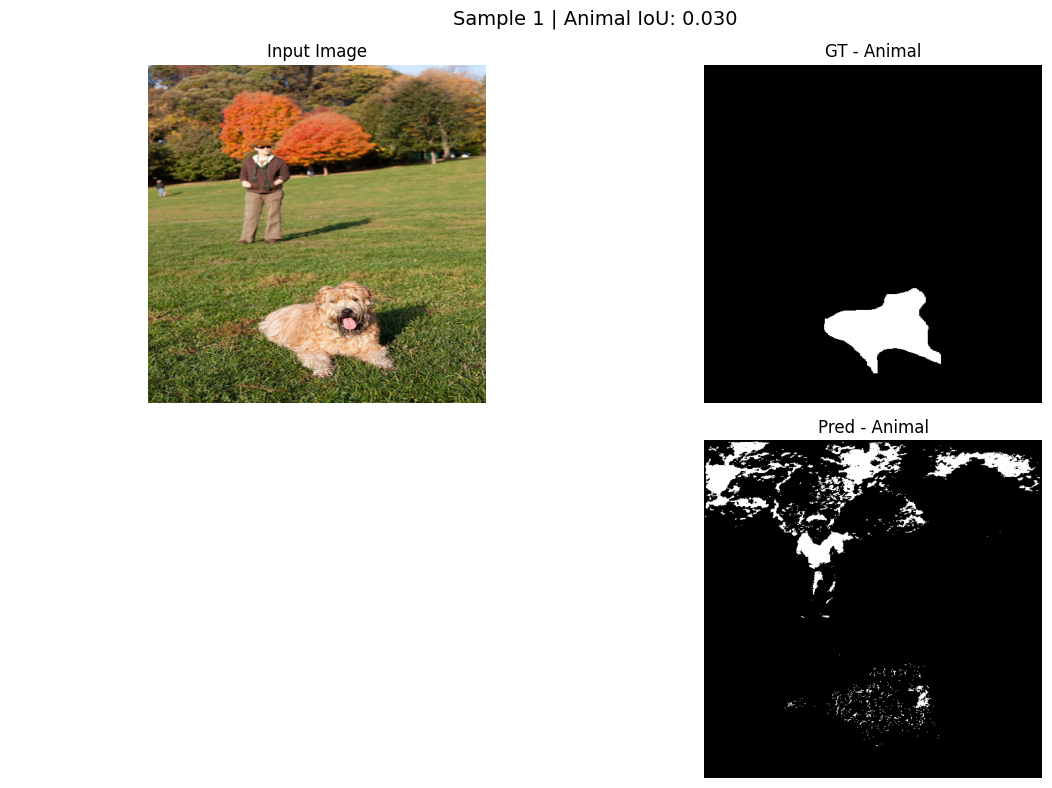

Aloo


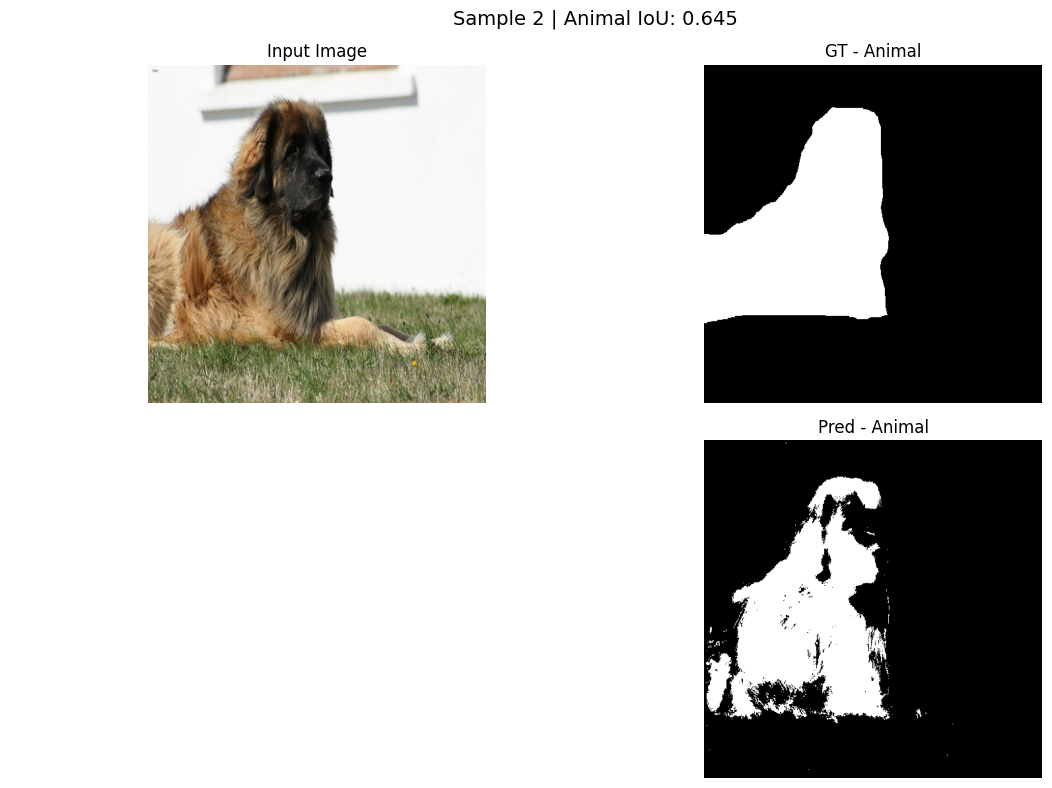

Aloo


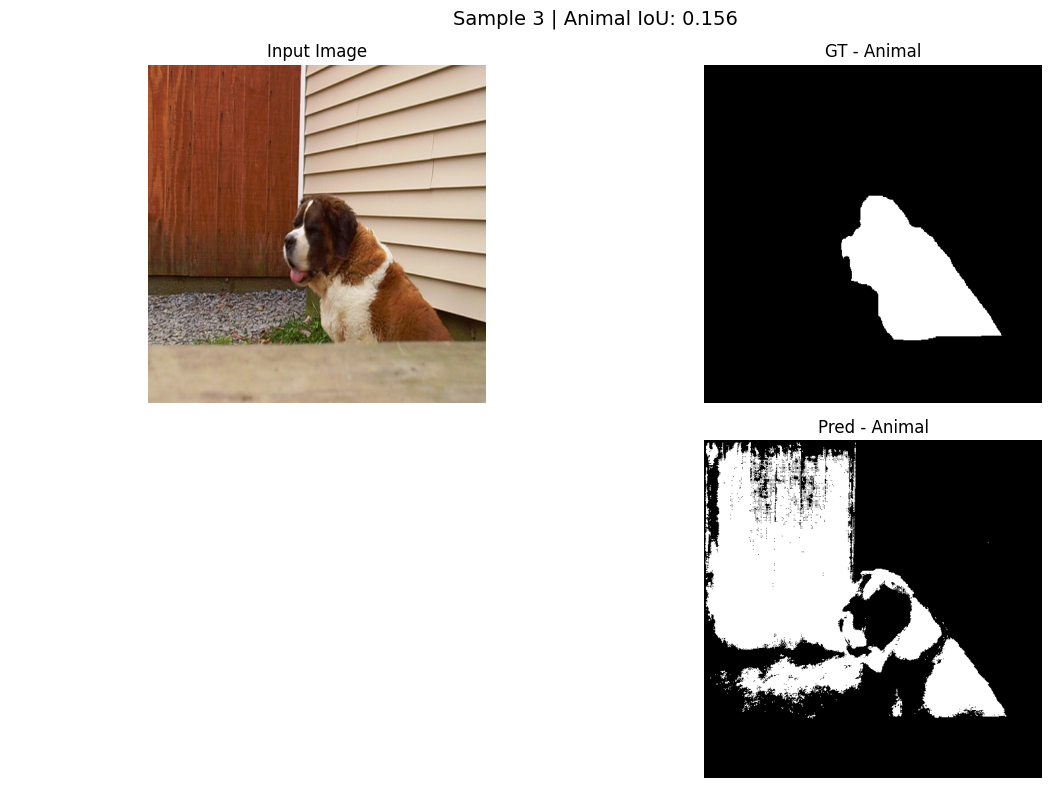


===== FINAL METRICS =====

Class: animal
precision: 0.4758
recall: 0.3915
f1: 0.3979
iou: 0.2804


In [21]:
testing(model, val_loader, device, num_batches=2)